<b><font size="5">Predicting the Aftermath of Flight Impacts with Animals</font></b>

In [2]:
### Imports

import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
import matplotlib
import pandas as pd
import seaborn as sns
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from datetime import date
import calendar

In [3]:
### Defining variables

backgroundColor = '#444444'
impColor = 'skyblue'
dmgColor = 'yellow'
injColor = 'orange'
fatColor = 'red'
legendColor = 'w'
titleSize = 36
axisLabelSize = 27
tickLabelSize = 18
legendTextSize = 18
standardCanvasHeight = 10
standardCanvasWidth = 20
predictionCols = ['Aircraft Damage', 'Injuries', 'Fatalities']
strikeLocations = ['Engine Strike', 'Fuselage Strike', 'Landing Gear Strike', 'Lights Strike', 'Nose Strike',
                   'Propeller Strike', 'Radome Strike', 'Tail Strike','Windshield Strike',
                   'Wing or Rotor Strike', 'Other Strike']
XCols = ['Aircraft', 'Aircraft Mass', 'Engines', 'Engine Type', 'Height', 'Speed',
         'Species Name', 'Species Quantity', 'Species Weight'] + strikeLocations
animalWeights = { # In kg
    'GULL': 0.935,
    'DEER': 56.65,
    'PIGEON': 0.141,
    'SPARROW': 0.03,
    'VULTURE': 1.5,
    'DUCK': 1.125,
    'HAWK': 1.145,
    'STARLING': 0.079,
    'GRACKLE': 0.108,
    'GOOSE': 4.0,
    'OWL': 2.019,
    'SWALLOW': 0.019,
    'HERON': 1.5,
    'EAGLE': 4.61,
    'DARTER': 1.2,
    'RAIL': 0.288,
    'GREBE': 0.91,
    'OSPREY': 1.4,
    'UNKSMLBIRD': 0.079, # Same as STARLING
    'UNKMEDBIRD': 0.935, # Same as GULL
    'UNKLRGBIRD': 4.61, # Same as EAGLE
    'UNKNOWNBIRD': 0.935  # Same as GULL
}

In [4]:
### Setting up dataframe

# Used to create Engine Strike col
def hasEngineStrike(row):
    return int(row['Engine1 Strike']==1 or row['Engine2 Strike']==1 
               or row['Engine3 Strike']==1 or row['Engine4 Strike']==1)

# Renames one or more animals species to have a common name
def renameBirdGroup(df, keys, name):
    for key in keys:
        df.loc[(df['Species Name'].str.contains(key)), 'Species Name'] = name
        
# Converts YYYY, MM, DD to YYYY.XXXX
def getPreciseYear(row):
    dayInYear = date(row['Incident Year'], int(row['Incident Month']), row['Incident Day']).timetuple().tm_yday
    daysInYear = 365 + calendar.isleap(row['Incident Year'])
    return row['Incident Year'] + dayInYear/daysInYear

# Importing raw data
impacts = pd.read_csv('database.csv', dtype={'Species Quantity': 'str', 'Aircraft Mass': 'str'}, low_memory=False)

# Removing null values
impacts = impacts[impacts['Height'].notnull()]
impacts = impacts[impacts['Speed'].notnull()]
impacts = impacts[impacts['Species Name'].notnull()]
impacts = impacts[impacts['Species Quantity'].notnull()]
impacts = impacts[impacts['Engines'].notnull()]
impacts = impacts[impacts['Engine Type'].notnull()]
impacts = impacts[impacts['Aircraft Mass'].notnull()]

# Modifying/Adding cols
impacts['Height'] = impacts['Height'].divide(3.28084) # feet to m
impacts['Speed'] = impacts['Speed'].multiply(1.852) # knots to km/h
impacts['Engine Strike'] = impacts.apply(lambda row: hasEngineStrike(row), axis=1)
impacts['Species Name'] = impacts['Species Name'].str.upper()
impacts['Fatalities'] = impacts.apply(lambda row: int(row['Fatalities'] > 0), axis=1) # 1 if any, 0 otherwise
impacts['Injuries'] = impacts.apply(lambda row: int(row['Injuries'] > 0), axis=1) # 1 if any, 0 otherwise

impacts = impacts[~impacts['Engine Type'].isin(['X', 'c', 'B/D', 'A/C'])] # Removing very rare categories

# Removing unneeded cols
impacts = impacts.drop(['Record ID', 'Airport ID', 'Operator ID', 'Operator', 'Aircraft Type', 'Aircraft Make', 
                        'Aircraft Model', 'Engine Make', 'Engine Model', 'Airport', 'State', 'FAA Region', 
                        'Warning Issued', 'Radome Damage', 'Flight Impact', 'Flight Phase', 'Windshield Damage', 
                        'Nose Damage', 'Engine4 Position', 'Engine1 Damage', 'Engine2 Damage', 'Engine1 Strike', 
                        'Engine3 Damage', 'Engine4 Damage', 'Engine4 Strike', 'Engine Ingested', 'Propeller Damage', 
                        'Distance', 'Wing or Rotor Damage', 'Engine3 Strike', 'Species ID', 'Fuselage Damage', 
                        'Landing Gear Damage', 'Engine2 Strike', 'Tail Damage', 'Lights Damage', 'Visibility',
                        'Other Damage', 'Flight Phase', 'Precipitation', 'Engine Ingested', 'Engine1 Position', 
                        'Engine2 Position', 'Engine3 Position'], axis = 1)

# Grouping and renaming animals
renameBirdGroup(impacts, ['VULTURE'], 'VULTURE')
renameBirdGroup(impacts, ['GOOSE', 'GEESE', 'BRANT'], 'GOOSE')
renameBirdGroup(impacts, ['GULL'], 'GULL')
renameBirdGroup(impacts, ['DEER', 'MOOSE', 'ELK', 'PRONGHORN'], 'DEER')
renameBirdGroup(impacts, ['ELK'], 'ELK')
renameBirdGroup(impacts, ['HAWK', 'HARRIER', 'KESTREL'], 'HAWK')
renameBirdGroup(impacts, ['DOVE', 'PIGEON'], 'PIGEON')
renameBirdGroup(impacts, ['EAGLE'], 'EAGLE')
renameBirdGroup(impacts, ['OWL'], 'OWL')
renameBirdGroup(impacts, ['HERON', 'BITTERN', 'EGRET'], 'HERON')
renameBirdGroup(impacts, ['CRANE'], 'CRANE')
renameBirdGroup(impacts, ['SPARROW', 'JUNCO'], 'SPARROW')
renameBirdGroup(impacts, ['STARLING', 'MYNA'], 'STARLING')
renameBirdGroup(impacts, ['SWALLOW', 'MARTIN'], 'SWALLOW')
renameBirdGroup(impacts, ['LOON'], 'LOON')
renameBirdGroup(impacts, ['BLACKBIRD', 'COWBIRD', 'ORIOLE', 'GRACKLE'], 'GRACKLE')
renameBirdGroup(impacts, ['LARK'], 'LARK')
renameBirdGroup(impacts, ['ROBIN', 'THRUSH'], 'ROBIN')
renameBirdGroup(impacts, ['PLOVER', 'LAPWING'], 'PLOVER')
renameBirdGroup(impacts, ['SWIFT'], 'SWIFT')
renameBirdGroup(impacts, ['CROW'], 'CROW')
renameBirdGroup(impacts, ['UNKNOWN LARGE BIRD'], 'UNK LRG BIRD')
renameBirdGroup(impacts, ['UNKNOWN MEDIUM BIRD'], 'UNK MED BIRD')
renameBirdGroup(impacts, ['UNKNOWN SMALL BIRD', 'PERCHING BIRDS'], 'UNK SML BIRD')
renameBirdGroup(impacts, ['UNKNOWN BIRD', 'SHOREBIRD'], 'UNKNOWN BIRD')
renameBirdGroup(impacts, ['MAGPIE'], 'MAGPIE')
renameBirdGroup(impacts, ['BUNTING'], 'BUNTING')
renameBirdGroup(impacts, ['WAXWING'], 'WAXWING')
renameBirdGroup(impacts, ['FALCON', 'MERLIN', 'CARACARA'], 'FALCON')
renameBirdGroup(impacts, ['WARBLER', 'YELLOWTHROAT', 'REDSTART', 'OVENBIRD'], 'WARBLER')
renameBirdGroup(impacts, ['COOT', 'RAIL', 'SORA', 'MOORHEN', 'GALLINULE'], 'RAIL')
renameBirdGroup(impacts, ['CORMORANT'], 'CORMORANT')
renameBirdGroup(impacts, ['GREBE'], 'GREBE')
renameBirdGroup(impacts, ['FRIGATEBIRD'], 'FRIGATEBIRD')
renameBirdGroup(impacts, ['IBIS'], 'IBIS')
renameBirdGroup(impacts, ['TROPICBIRD'], 'TROPICBIRD')
renameBirdGroup(impacts, ['PELICAN'], 'PELICAN')
renameBirdGroup(impacts, ['PHEASANT', 'TURKEY', 'GROUSE', 'PARTRIDGE', 'PTARMIGAN'], 'TURKEY')
renameBirdGroup(impacts, ['SWAN'], 'SWAN')
renameBirdGroup(impacts, ['RAVEN'], 'RAVEN')
renameBirdGroup(impacts, ['FINCH', 'MUNIA', 'GROSBEAK'], 'FINCH')
renameBirdGroup(impacts, ['CATBIRD'], 'CATBIRD')
renameBirdGroup(impacts, ['RABBIT', 'COTTONTAIL', 'HARE'], 'RABBIT')
renameBirdGroup(impacts, ['SKUNK'], 'SKUNK')
renameBirdGroup(impacts, ['KINGBIRD'], 'KINGBIRD')
renameBirdGroup(impacts, ['PIPIT'], 'PIPIT')
renameBirdGroup(impacts, ['FLYCATCHER'], 'FLYCATCHER')
renameBirdGroup(impacts, ['PIPIT'], 'PIPIT')
renameBirdGroup(impacts, ['TERN'], 'TERN')
renameBirdGroup(impacts, ['OPOSSUM'], 'OPOSSUM')
renameBirdGroup(impacts, ['FOX'], 'FOX')
renameBirdGroup(impacts, ['VIREO'], 'VIREO')
renameBirdGroup(impacts, ['FLICKER', 'WOODPECKER', 'SAPSUCKER'], 'WOODPECKER')
renameBirdGroup(impacts, ['WOODCOCK'], 'WOODCOCK')
renameBirdGroup(impacts, ['SNIPE'], 'SNIPE')
renameBirdGroup(impacts, ['KITE'], 'KITE')
renameBirdGroup(impacts, ['CUCKOO'], 'CUCKOO')
renameBirdGroup(impacts, ['STORK'], 'STORK')
renameBirdGroup(impacts, ['TURTLE', 'TERRAPIN'], 'TURTLE')
renameBirdGroup(impacts, ['ANHINGA'], 'DARTER')
renameBirdGroup(impacts, ['TANAGER'], 'TANAGER')
renameBirdGroup(impacts, ['CHICKADEE'], 'CHICKADEE')
renameBirdGroup(impacts, ['QUAIL', 'BOBWHITE'], 'QUAIL')
renameBirdGroup(impacts, ['DUNLIN', 'STINT'], 'STINT')
renameBirdGroup(impacts, ['DOG', 'CANIDS'], 'DOG')
renameBirdGroup(impacts, ['BAT', 'MYOTIS'], 'BAT')
renameBirdGroup(impacts, ['WREN'], 'WREN')
renameBirdGroup(impacts, ['SANDPIPER', 'SANDERLING', 'WHIMBREL', 'DOWITCHER', 'GODWIT',
                          'PHALAROPE', 'DUNLIN', 'STINT'], 'SANDPIPER')
renameBirdGroup(impacts, ['MALLARD', 'DUCK', 'PINTAIL', 'WIGEON', 'SHOVELER', 'MERGANSER', 'GOLDENEYE', 'EIDER',
                          'TEAL', 'GADWALL', 'CANVASBACK', 'SCAUP', 'REDHEAD', 'BUFFLEHEAD', 'SCOTER'], 'DUCK')

# Collecting the top 'nInclude' animals to not cause damage, cause damage, cause injury, and cause death
nInclude = 10

impactsNoDmg = impacts[impacts['Aircraft Damage'] == 0]
animalsToInclude = impactsNoDmg['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impactsDmg = impacts[impacts['Aircraft Damage'] == 1]
animalsToInclude += impactsDmg['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impactsInj = impacts[impacts['Injuries'] == 1]
animalsToInclude += impactsInj['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impactsFat = impacts[impacts['Fatalities'] == 1]
animalsToInclude += impactsFat['Species Name'].value_counts().nlargest(nInclude).index.tolist()

impacts = impacts[impacts['Species Name'].isin(animalsToInclude)] # Only keep top animals

# Modifying/Adding more cols
impacts['Species Weight'] = impacts['Species Name'].apply(lambda row: animalWeights[str(row.replace(' ', ''))])    
impacts['Precise Year'] = impacts.apply(lambda row: getPreciseYear(row), axis=1)

# Reording cols
impacts = impacts[['Precise Year', 'Incident Year', 'Incident Month', 'Incident Day', 'Height', 'Speed', 'Aircraft',
                   'Aircraft Mass', 'Engines', 'Engine Type', 'Species Name', 'Species Quantity', 'Species Weight']
                  + strikeLocations + predictionCols]

nImpacts = len(impacts)

In [5]:
### Quick stats

# Date formatter
def getFormattedDateAtIndex(i):
    return f"{impacts['Incident Year'].iloc[i]}-{impacts['Incident Month'].iloc[i]}-{impacts['Incident Day'].iloc[i]}"

# Interesting Stats
print(f"Date Range Start: {getFormattedDateAtIndex(0)}")
print(f"Date Range End: {getFormattedDateAtIndex(-1)}\n")

print(f"Number of Impacts: {nImpacts}")
print(f"Number of Damaged Aircrafts: {int(impacts['Aircraft Damage'].sum())}")
print(f"Number of Injuries: {int(impacts['Injuries'].sum())}")
print(f"Number of Fatalities: {int(impacts['Fatalities'].sum())}\n")

print(f"Damaged Aircraft Rate: {round(impacts['Aircraft Damage'].sum()/nImpacts, 3)}")
print(f"Injury Rate: {round(impacts['Injuries'].sum()/nImpacts, 4)}")
print(f"Fatality Rate: {'%f' % round(impacts['Fatalities'].sum()/nImpacts, 6)}\n")

print(f"Ground Impact Rate: {round((len(impacts[impacts['Height'] == 0])/nImpacts), 3)}")
impactsKnownAnimal = impacts[~impacts['Species Name'].str.contains('UNK')]
print(f"Unknown Animal Rate: {round(1-(len(impactsKnownAnimal)/nImpacts), 3)}\n")

print('Impact Location Rates:')
round(impacts[strikeLocations].mean().sort_values(ascending=False), 3)

Date Range Start: 1990-1-3
Date Range End: 2015-9-30

Number of Impacts: 58628
Number of Damaged Aircrafts: 7357
Number of Injuries: 123
Number of Fatalities: 5

Damaged Aircraft Rate: 0.125
Injury Rate: 0.0021
Fatality Rate: 0.000085

Ground Impact Rate: 0.264
Unknown Animal Rate: 0.645

Impact Location Rates:


Windshield Strike       0.242
Nose Strike             0.204
Radome Strike           0.181
Fuselage Strike         0.161
Wing or Rotor Strike    0.154
Engine Strike           0.118
Landing Gear Strike     0.056
Other Strike            0.047
Propeller Strike        0.033
Tail Strike             0.018
Lights Strike           0.009
dtype: float64

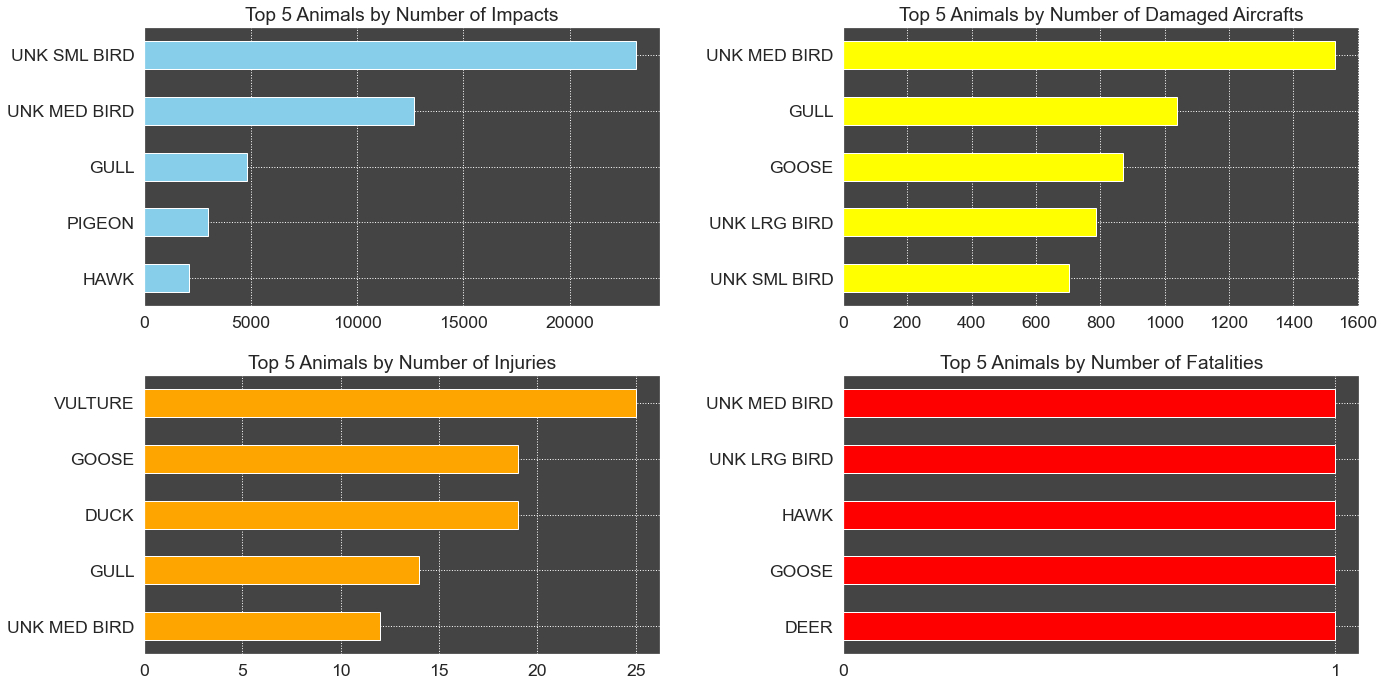

In [14]:
###  Comparing the top animals

# Number of animals to show per plot
numAnimals = 5

matplotlib.rc('font', size=20)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

impTop = impacts['Species Name'].value_counts()[:numAnimals][::-1]
impTop.plot(ax=ax1, kind='barh', title='Top 5 Animals by Number of Impacts', color=impColor, ylabel='Species Name')

dmgTop = impacts[['Species Name', 'Aircraft Damage']]
dmgTop = dmgTop.groupby(by='Species Name')['Aircraft Damage'].sum().sort_values(ascending = False)[:numAnimals][::-1]
dmgTop.plot(ax=ax2, kind='barh', title='Top 5 Animals by Number of Damaged Aircrafts', color=dmgColor)

injTop = impacts[['Species Name', 'Injuries']]
injTop = injTop.groupby(by='Species Name')['Injuries'].sum().sort_values(ascending = False)[:numAnimals][::-1]
injTop.plot(ax=ax3, kind='barh', title='Top 5 Animals by Number of Injuries', color=injColor)

fatTop = impacts[['Species Name', 'Fatalities']]
fatTop = fatTop.groupby(by='Species Name')['Fatalities'].sum().sort_values(ascending = False)[:numAnimals][::-1]
fatTop.plot(ax=ax4, kind='barh', title='Top 5 Animals by Number of Fatalities', color=fatColor)

fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
fig.tight_layout(pad=1.2)

for a in [ax1, ax2, ax3, ax4]:
    a.set_ylabel('')
    a.grid(axis='both', which='major', linestyle='dotted')
ax4.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.rcParams['axes.facecolor'] = backgroundColor

plt.show()

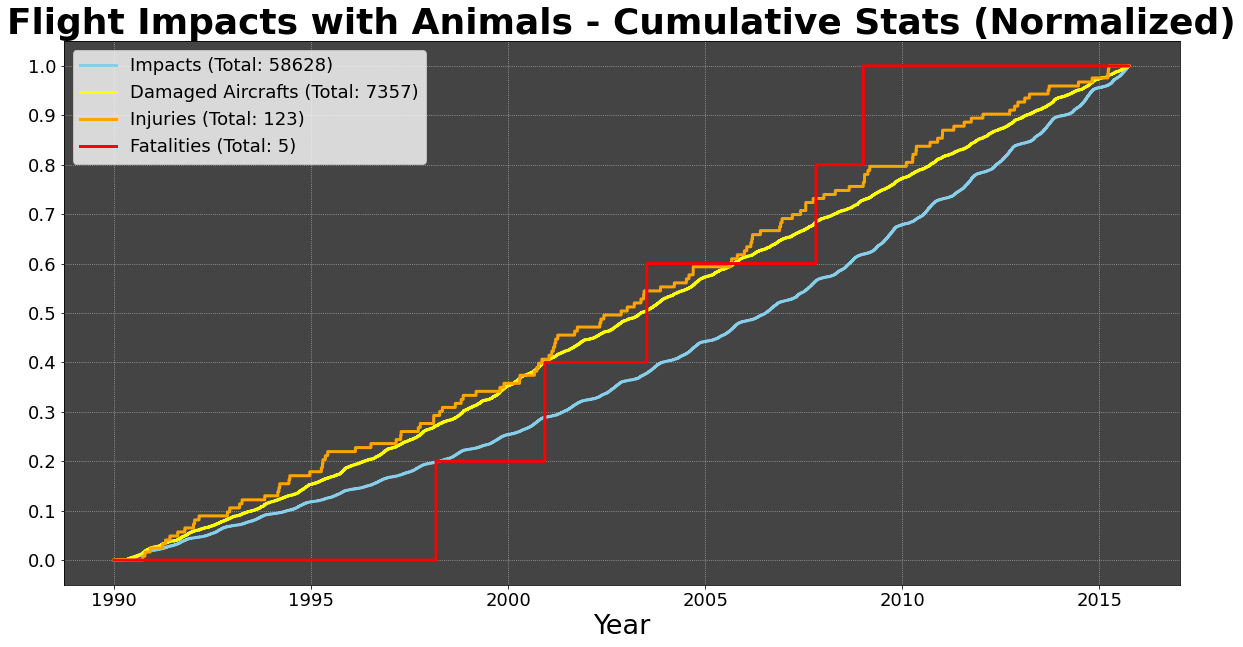

In [7]:
### Cumulative stats plot

# Cumulative sums
impCum = np.arange(1, nImpacts + 1)
dmgCum = impacts['Aircraft Damage'].cumsum()
injCum = impacts['Injuries'].cumsum()
fatCum = impacts['Fatalities'].cumsum()

# Legend labels
impLabel = f"Impacts (Total: {impCum.max()})"
dmgLabel = f"Damaged Aircrafts (Total: {dmgCum.max()})"
injLabel = f"Injuries (Total: {injCum.max()})"
fatLabel = f"Fatalities (Total: {fatCum.max()})"

# Plotting
ax = plt.gca()
fig = plt.gcf()
ax.set_title("Flight Impacts with Animals - Cumulative Stats (Normalized)", size=titleSize, fontweight="bold")
plt.step(impacts['Precise Year'], impCum/impCum.max(), label=impLabel, linewidth=3, color=impColor)
plt.step(impacts['Precise Year'], dmgCum/dmgCum.max(), label=dmgLabel, linewidth=3,color=dmgColor)
plt.step(impacts['Precise Year'], injCum/injCum.max(), label=injLabel, linewidth=3, color=injColor)
plt.step(impacts['Precise Year'], fatCum/fatCum.max(), label=fatLabel, linewidth=3, color=fatColor)
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.grid(axis="both", which="both", linestyle= 'dotted')
ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
plt.legend(facecolor=legendColor, prop={'size': legendTextSize})
plt.locator_params(axis='y', nbins=11)
plt.xlabel("Year", size=axisLabelSize)
plt.rcParams['axes.facecolor'] = backgroundColor
plt.show()

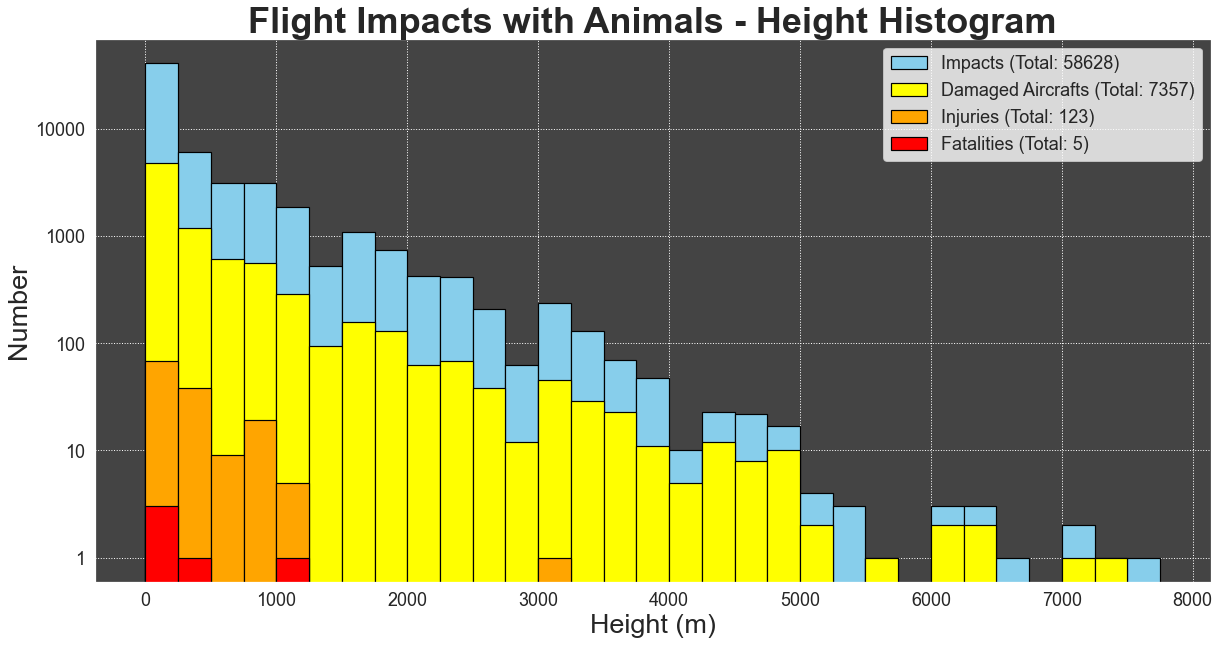

In [27]:
### Height Histogram

# Used to generate histograms for Height and Speed
def generateHistogram(col, units, binWidth):
    binMax = int(impacts[col].max()) + binWidth

    ax = plt.gca()
    fig = plt.gcf()
    ax.set_title(f"Flight Impacts with Animals - {col} Histogram", size=titleSize, fontweight='bold')
    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    plt.rcParams['axes.facecolor'] = backgroundColor
    plt.hist(impacts[col], bins=range(0, binMax, binWidth), label=impLabel, edgecolor='black',
             linewidth=1.2, color=impColor)
    plt.hist(impactsDmg[col], bins=range(0, binMax, binWidth), label=dmgLabel, edgecolor='black',
             linewidth=1.2, color=dmgColor)
    plt.hist(impactsInj[col], bins=range(0, binMax, binWidth), label=injLabel, edgecolor='black',
             linewidth=1.2, color=injColor)
    plt.hist(impactsFat[col], bins=range(0, binMax, binWidth), label=fatLabel, edgecolor='black',
             linewidth=1.2, color=fatColor)
    ax.set_yscale('log')
    plt.grid(axis='both', which="major", linestyle= 'dotted')
    ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
    plt.xlabel(f"{col} ({units})", size=axisLabelSize)
    plt.ylabel("Number", size=axisLabelSize)
    
    if col == 'Speed':
        ax.axvspan(225, 300, alpha=0.5, color='lightgreen', label='Takeoff/Landing Speed')
    plt.legend(facecolor=legendColor, prop={'size': legendTextSize})
    
    plt.show()
    
generateHistogram('Height', 'm', 250)

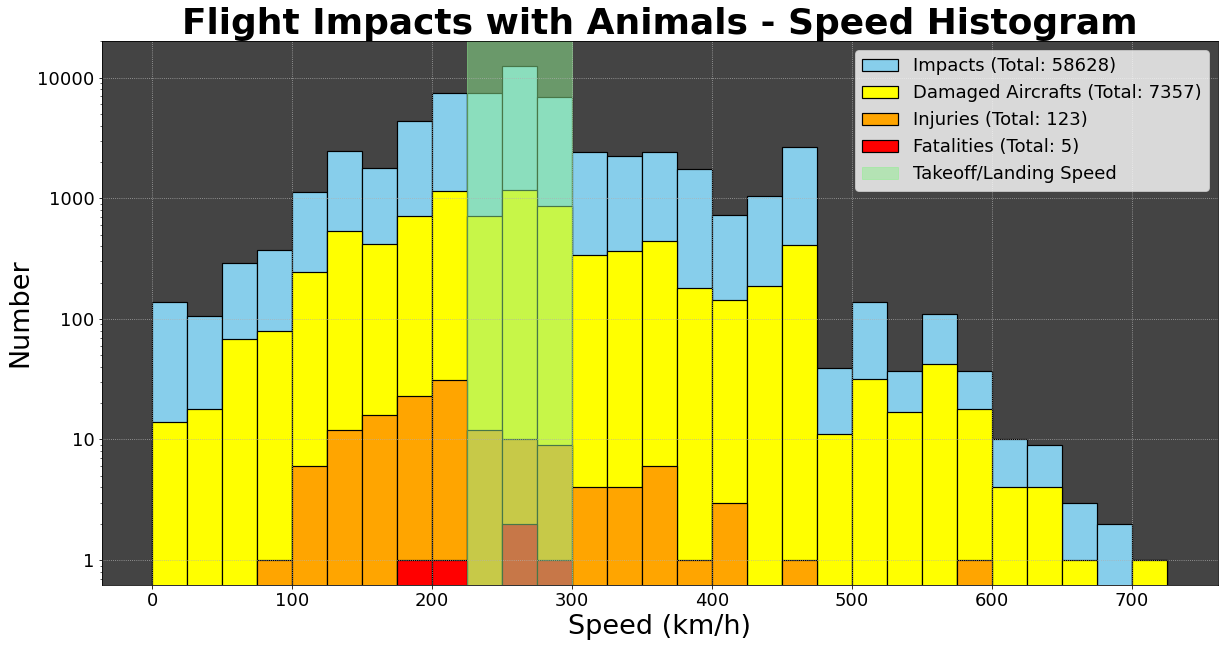

In [9]:
### Speed Histogram

generateHistogram('Speed', 'km/h', 25)

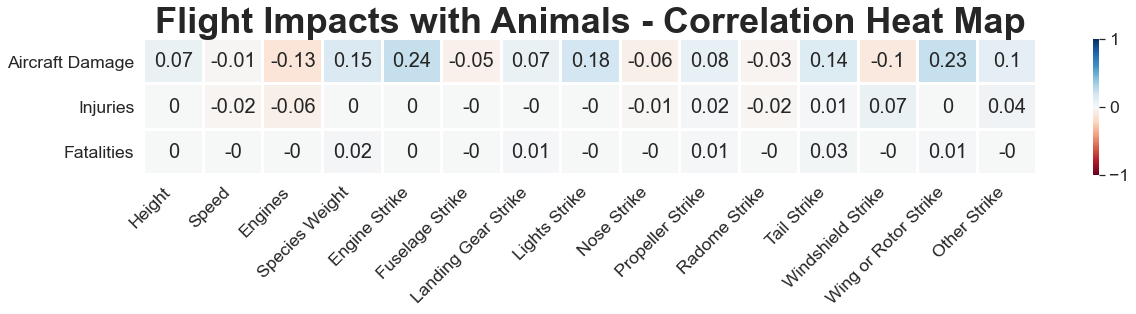

In [12]:
### Correlation Heat Map

# Removing unintersting cols
impactsCorr = impacts.drop(['Precise Year', 'Incident Year', 'Incident Month', 'Incident Day'], axis=1)
corr = impactsCorr.corr().round(2)
corr = corr.drop(predictionCols, axis=1)
corr = corr.drop(strikeLocations + ['Engines', 'Height', 'Speed', 'Species Weight'], axis=0)

heatmap = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap="RdBu", linewidths=2)
sns.set(rc={"figure.figsize":(standardCanvasWidth, standardCanvasHeight*0.25)})
sns.set(font_scale=1.6)
ax = plt.gca()
ax.set_title("Flight Impacts with Animals - Correlation Heat Map", size=titleSize, fontweight="bold")
ax.set_xticklabels(corr.columns, rotation = 45, ha="right")
plt.show()

In [15]:
### Finding best estimator(s)

# Catagorical col encoding
one_hot = OneHotEncoder(categories=[impacts['Aircraft'].unique(),
                                    impacts['Aircraft Mass'].unique(), # 5 categories
                                    impacts['Engine Type'].unique(),
                                    impacts['Species Name'].unique(),
                                    impacts['Species Quantity'].unique()])
transformer = ColumnTransformer([('one_hot', one_hot,
                                ['Aircraft', 'Aircraft Mass', 'Engine Type',
                                 'Species Name','Species Quantity'])],
                                remainder='passthrough')
impactsX_t = transformer.fit_transform(impacts[XCols])

# Compares Random Forest Classifier, KNN Classifier, and SVC
def findBestEstimator(col):
    y = impacts.loc[:, col]
    X_train, X_test, y_train, y_test = train_test_split(impactsX_t, y, test_size=0.2)

    colUp = col.upper()
    print(f"{colUp} ESTIMATOR SCORES:")

    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    scores = {'Random Forest Classifier': round(model.score(X_test, y_test), 3)}
    
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    scores.update({'KNN Classifier': round(model.score(X_test, y_test), 5)})
    
    model = SVC()
    model.fit(X_train, y_train)
    scores.update({'SVC': round(model.score(X_test, y_test), 5)})

    for score in scores:
        print(f"{score}: {scores[score]}")
    print('\n')
    
    print(f"BEST {colUp} ESTIMATOR: {max(scores, key=scores.get)}\n")

# Finding best estimator for Aircraft Damage, Injuries, and Fatalities
for col in predictionCols:
    findBestEstimator(col)

AIRCRAFT DAMAGE ESTIMATOR SCORES:
Random Forest Classifier: 0.903
KNN Classifier: 0.88129
SVC: 0.87788


BEST AIRCRAFT DAMAGE ESTIMATOR: Random Forest Classifier

INJURIES ESTIMATOR SCORES:
Random Forest Classifier: 0.998
KNN Classifier: 0.9977
SVC: 0.9977


BEST INJURIES ESTIMATOR: Random Forest Classifier

FATALITIES ESTIMATOR SCORES:
Random Forest Classifier: 1.0
KNN Classifier: 1.0
SVC: 1.0


BEST FATALITIES ESTIMATOR: Random Forest Classifier



In [21]:
### Generating and saving datamodels

cvGrid = {"n_estimators": [100, 250, 500],
          "max_depth": [5, 10, 20],
          "min_samples_split": [2, 4, 8],
          "min_samples_leaf": [1, 2, 4]}

# Generate and saves a Random Forest Classifier model
def generateRFC(col):
    y = impacts.loc[:, col]
    X_train, X_test, y_train, y_test = train_test_split(impactsX_t, y, test_size=0.2)
    
    model = RandomForestClassifier()
    model = RandomizedSearchCV(estimator=model, param_distributions=cvGrid, n_iter=81, cv=5, verbose=0)
    model.fit(X_train, y_train)
    
    pickle.dump(model, open(f"ByeByeBirdy_{col.replace(' ', '')}Model.sav", 'wb'))
    print(f"{col} Model Score: {round(model.score(X_test, y_test), 6)}")

# Generating models for Aircraft Damage, Injuries, and Fatalities
# for col in predictionCols:
#     generateRFC(col)

In [22]:
### Functions to help choose model inputs and to help make predictions

# Help set up model predictions
def getPredRowStart(aircraft, animal, quantity, height, speed):
    X = impacts[['Aircraft','Aircraft Mass','Engines','Engine Type']][impacts['Aircraft'] == aircraft]
    X = pd.DataFrame(X.iloc[0]).transpose()
    
    X['Height'] = height
    X['Speed'] = speed
    X['Species Name'] = animal
    X['Species Quantity'] = quantity
    X['Species Weight'] = animalWeights[animal.replace(' ', '')]
    return X

# Get prediction results 
def getResultSummary(X, cols):
    X_t = transformer.fit_transform(X)
    
    resultSummary = pd.DataFrame(columns=cols)
    
    for col in predictionCols:
        model = pickle.load(open(f"ByeByeBirdy_{col.replace(' ', '')}Model.sav", 'rb'))
        resultRow = [col] + list(model.predict_proba(X_t)[:, 1])
        resultSummary = resultSummary.append(pd.Series(resultRow, index=cols), ignore_index=True) 

    resultSummary = resultSummary.set_index('Prediction Type')
    resultSummary.index.name = None
    return resultSummary

# Get predictions for an impact with the impact location(s) specified
def customImpact(aircraft, animal, quantity, height, speed, customImpacts):
    X = getPredRowStart(aircraft, animal, quantity, height, speed)
    
    for loc in customImpacts:
        X[loc] = customImpacts[loc]
    
    return getResultSummary(X, ['Prediction Type', 'Probability'])

# Generate a table showing the prediction for each possible impact location (1 location per impact)
def impactStrikeTable(aircraft, animal, quantity, height, speed):
    
    X_common = getPredRowStart(aircraft, animal, quantity, height, speed)
    X = pd.DataFrame(columns=XCols)
    
    for i, strikeLocation in enumerate(strikeLocations):
        X_row = X_common.copy()
        X_row_strikes = [0] * len(strikeLocations)
        X_row_strikes[i] = 1
        X_row_strikes = pd.DataFrame([X_row_strikes], columns=strikeLocations)
        X_row = pd.concat([X_row.reset_index().drop(['index'], axis=1),
                           X_row_strikes.reset_index().drop(['index'], axis=1)], axis=1)
        X = pd.concat([X, X_row])
        
    resultSummaryCols = ['Prediction Type'] + strikeLocations
    return getResultSummary(X, resultSummaryCols)

# Find the top "num" aircrafts with the specified mass, number of engines, and engine type
def findAircrafts(mass = None, engines = None, engineType = None, num = 1):
    aircraftTypes = impacts
    if (mass != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Aircraft Mass'] == mass]
    if (engines != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Engines'] == engines]
    if (engineType != None):
        aircraftTypes = aircraftTypes[aircraftTypes['Engine Type'] == engineType]
    
    if len(aircraftTypes) == 0:
        print('No matching aircrafts found...\n')
    else:
        print(str(aircraftTypes[['Aircraft','Aircraft Mass','Engines','Engine Type']]
                  .value_counts().nlargest(num)) + '\n')

In [28]:
### Info to help choose model inputs

print('INFO FOR SELECTING INPUTS:\n')

print('Most Common Aircrafts (Filtered):')
findAircrafts(mass='1', engines=2, num=5)

print('Animals by Count:')
print(str(impacts['Species Name'].value_counts()) + '\n')

print('Animal Quantity by Count:')
print(str(impacts['Species Quantity'].value_counts()) + '\n')

print('Height and Speed Stats:')
impacts[['Height', 'Speed']].describe()

INFO FOR SELECTING INPUTS:

Most Common Aircrafts (Filtered):
Aircraft        Aircraft Mass  Engines  Engine Type
C-560           1              2.0      D              382
BE-300 KING     1              2.0      C              139
PA-34 SENECA    1              2.0      A               90
BE-76  DUCHESS  1              2.0      A               46
DIAMOND 42      1              2.0      C               16
dtype: int64

Animals by Count:
UNK SML BIRD    23095
UNK MED BIRD    12701
GULL             4822
PIGEON           3015
HAWK             2101
UNK LRG BIRD     2013
SWALLOW          1962
SPARROW          1852
GOOSE            1440
STARLING         1353
GRACKLE          1190
DUCK             1117
DEER              980
VULTURE           785
EAGLE             130
RAIL               72
Name: Species Name, dtype: int64

Animal Quantity by Count:
1           48617
2-10         9399
11-100        585
Over 100       27
Name: Species Quantity, dtype: int64

Height and Speed Stats:


,Height,Speed
count,58628.000000,58628.000000
mean,324.503349,264.103988
std,595.326393,84.739037
min,0.000000,0.000000
25%,0.000000,222.240000
50%,60.959998,257.428000
75%,365.759988,296.320000
max,7619.999756,703.760000


In [30]:
### Predictions by strike location (1 strike location per impact)

impactStrikeTable('BE-76  DUCHESS', 'GULL', '11-100', 150, 300)

,Engine Strike,Fuselage Strike,Landing Gear Strike,Lights Strike,Nose Strike,Propeller Strike,Radome Strike,Tail Strike,Windshield Strike,Wing or Rotor Strike,Other Strike
Aircraft Damage,0.357891,0.274374,0.274371,0.551762,0.318655,0.280359,0.325866,0.462794,0.289558,0.425536,0.344024
Injuries,0.018780,0.015252,0.010181,0.011029,0.012543,0.010747,0.010649,0.009601,0.027579,0.009240,0.012947
Fatalities,0.000056,0.000144,0.000165,0.000167,0.000056,0.000166,0.000161,0.000263,0.000176,0.000211,0.000162


In [32]:
### Predictions with specific strike locations

impactLocations = {
    'Engine Strike': 1,
    'Fuselage Strike': 1,
    'Landing Gear Strike': 1,
    'Lights Strike': 1,
    'Nose Strike': 1,
    'Propeller Strike': 1,
    'Radome Strike': 1,
    'Tail Strike': 1,
    'Windshield Strike': 1,
    'Wing or Rotor Strike': 1,
    'Other Strike': 1
}

customImpact('BE-76  DUCHESS', 'GULL', '1', 150, 300, impactLocations)

,Probability
Aircraft Damage,0.665623
Injuries,0.014451
Fatalities,0.000088
